## Descripción del proyecto
Trabajas en una empresa emergente que vende productos alimenticios. Debes investigar el comportamiento del usuario para la aplicación de la empresa.
Investigar el embudo de ventas y sacar conclusiones para, luego observar los resultados de un test A/A/B y así tomar una decisión basada en los resultados de este mismo.

## Objetivo
Investigar el comportamiento del usuario para la aplicación de la empresa.


## Etapas del proyecto
* Abrir el archivo de datos y leer la información general
* Preparar los datos para el análisis
* Estudiar y comprobar los datos
* Estudiar el embudo de eventos
* Estudiar los resultados del experimento

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import scipy.stats as stats
import math as mth
from scipy import stats as st
import numpy as np

## Paso 1. Abrir el archivo de datos y leer la información general

---

In [2]:
try:
    df = pd.read_csv('/datasets/logs_exp_us.csv', sep = '\t')
except:
    df = pd.read_csv('/content/logs_exp_us.csv', sep = '\t')

In [3]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 22.9 MB


## Paso 2. Preparar los datos para el análisis


---

In [5]:
df.columns = ['event_name','user_id','time_event','exp_id']
df.head()

,event_name,user_id,time_event,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [6]:
df.duplicated().sum()

413

In [7]:
df = df.drop_duplicates().reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  243713 non-null  object
 1   user_id     243713 non-null  int64 
 2   time_event  243713 non-null  int64 
 3   exp_id      243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.4+ MB


In [8]:
df['time_event'] = pd.to_datetime(df['time_event'], unit='s')
df.head()

,event_name,user_id,time_event,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [9]:
df['date'] = df['time_event'].dt.date
df.head()

,event_name,user_id,time_event,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


## Paso 3. Estudiar y comprobar los datos


---

¿Cuántos eventos hay en los registros?

In [10]:
df.event_name.count()

243713

¿Cuántos usuarios y usuarias hay en los registros?

In [11]:
df.user_id.nunique()

7551

¿Cuál es el promedio de eventos por usuario?

In [12]:
user_event = df.groupby('user_id')['event_name'].count().mean()
user_event

32.27559263673685

¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima. Traza un histograma por fecha y hora. ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios o usuarias por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?

In [13]:
print(df.time_event.min())
print(df.time_event.max())

2019-07-25 04:43:36
2019-08-07 21:15:17


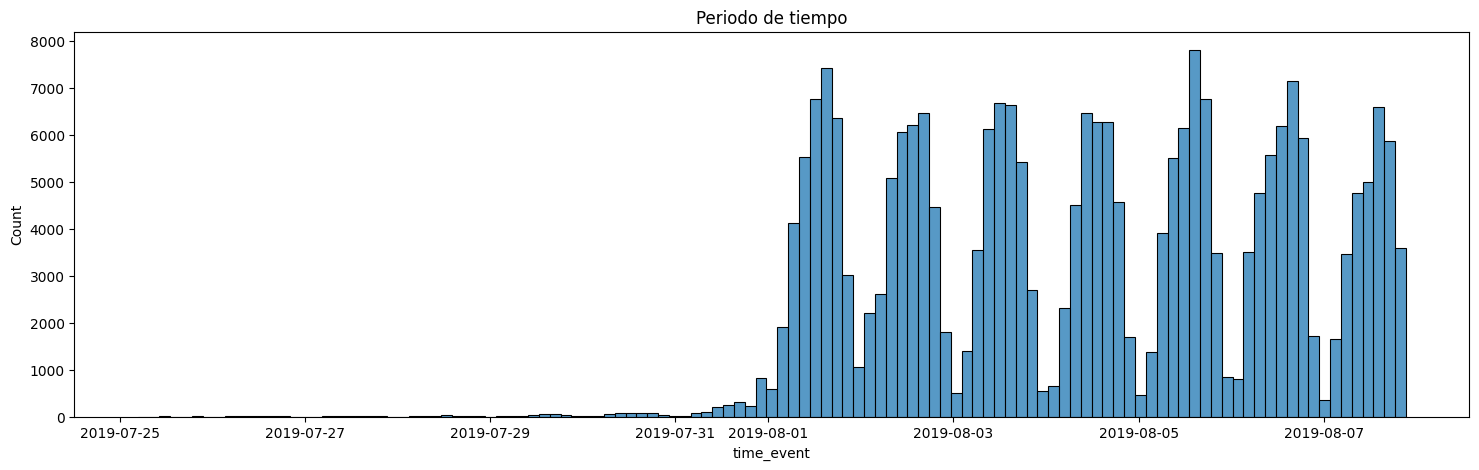

In [14]:
plt.figure(figsize=(18,5))
plt.title('Periodo de tiempo')
sns.histplot(df, x='time_event');

In [15]:
new_df = df.query('time_event >= "2019-08-01"')

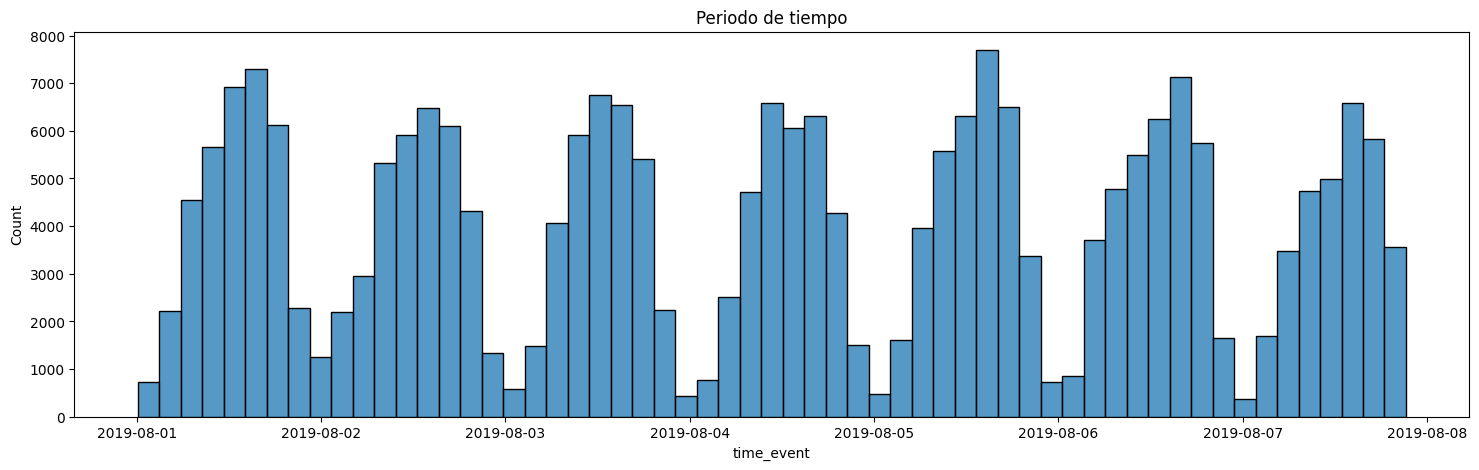

In [16]:
plt.figure(figsize=(18,5))
plt.title('Periodo de tiempo')
sns.histplot(new_df, x='time_event');

¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

In [17]:
df.query('time_event <= "2019-08-01"')

,event_name,user_id,time_event,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
2821,OffersScreenAppear,2413191300976302222,2019-07-31 23:54:55,247,2019-07-31
2822,MainScreenAppear,5505110279185484837,2019-07-31 23:57:30,247,2019-07-31
2823,MainScreenAppear,5505110279185484837,2019-07-31 23:57:42,247,2019-07-31
2824,MainScreenAppear,5505110279185484837,2019-07-31 23:57:52,247,2019-07-31


Asegúrate de tener usuarios y usuarias de los tres grupos experimentales.

In [18]:
x = new_df.groupby('exp_id')['user_id'].nunique()
x

exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

## Paso 4. Estudiar el embudo de eventos

---

In [19]:
df_a = df[df['exp_id'] == 246].reset_index()
df_a.head()

,index,event_name,user_id,time_event,exp_id,date
0,0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,6,OffersScreenAppear,8351860793733343758,2019-07-25 14:50:42,246,2019-07-25
3,7,MainScreenAppear,5682100281902512875,2019-07-25 20:14:37,246,2019-07-25
4,9,MainScreenAppear,5407636962369102641,2019-07-26 03:35:12,246,2019-07-26


In [20]:
df_a1 = df[df['exp_id'] == 247].reset_index()
df_a1.head()

,index,event_name,user_id,time_event,exp_id,date
0,8,MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,247,2019-07-25
1,10,MainScreenAppear,948465712512390382,2019-07-26 05:33:34,247,2019-07-26
2,13,MainScreenAppear,2140904690380565988,2019-07-26 07:22:12,247,2019-07-26
3,16,MainScreenAppear,5839517684026830712,2019-07-26 11:43:41,247,2019-07-26
4,18,CartScreenAppear,2575393697599976818,2019-07-26 13:49:05,247,2019-07-26


In [21]:
df_b = df[df['exp_id'] == 248].reset_index()
df_b.head()

,index,event_name,user_id,time_event,exp_id,date
0,2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
1,3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
2,4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
3,5,CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,248,2019-07-25
4,11,MainScreenAppear,2547684315586332355,2019-07-26 06:50:26,248,2019-07-26


In [22]:
df_ab = df_a[df_a['user_id'].isin(df_b['user_id'])].reset_index()
df_ab

,level_0,index,event_name,user_id,time_event,exp_id,date


In [23]:
df_aa = df_a1[df_a1['user_id'].isin(df_a['user_id'])].reset_index()
df_aa

,level_0,index,event_name,user_id,time_event,exp_id,date


In [24]:
df_a1b = df_a1[df_a1['user_id'].isin(df_b['user_id'])].reset_index()
df_a1b

,level_0,index,event_name,user_id,time_event,exp_id,date


Tras analizar los distintos grupos podemos ver que no existen filtraciones de usuarios entre estos.


---


Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.

In [25]:
new_df.event_name.value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Encuentra la cantidad de usuarios y usuarias que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios y usuarias. Calcula la proporción de usuarios y usuarias que realizaron la acción al menos una vez.

In [26]:
id_df = new_df.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()
id_df.columns = ['event','id_num']

In [27]:
id_df['user_poportion'] = round(id_df['id_num']/new_df['user_id'].nunique()*100,2)
id_df

,event,id_num,user_poportion
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.

In [28]:
new_df.event_name.value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

In [29]:
final_df = new_df.query('event_name != "Tutorial"')
final_df.head()

,event_name,user_id,time_event,exp_id,date
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
2831,MainScreenAppear,4899590676214355127,2019-08-01 00:10:15,247,2019-08-01


Utiliza el embudo de eventos para encontrar la proporción de usuarios y usuarias que pasan de una etapa a la siguiente. (Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B).

In [30]:
users = final_df.pivot_table(
    index='user_id', 
    columns='event_name', 
    values='time_event',
    aggfunc='min')

users.head()

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
user_id,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45


In [31]:
step_1 = ~users['MainScreenAppear'].isna()
step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

n_main_screen = users[step_1].shape[0]
n_offer_screen = users[step_2].shape[0]
n_cart_screen = users[step_3].shape[0]
n_payment = users[step_4].shape[0]

print('Pagina principal:', n_main_screen)
print('Pagina de oferta:', n_offer_screen)
print('Agregar al carro:', n_cart_screen)
print('Pagado:', n_payment)

Pagina principal: 7419
Pagina de oferta: 4201
Agregar al carro: 1767
Pagado: 454


In [32]:
group_a = final_df[final_df.exp_id==246].groupby(['event_name','exp_id'])['user_id'].nunique().reset_index().sort_values(by='user_id',ascending=False)
group_a

,event_name,exp_id,user_id
1,MainScreenAppear,246,2450
2,OffersScreenAppear,246,1542
0,CartScreenAppear,246,1266
3,PaymentScreenSuccessful,246,1200


In [33]:
group_b = final_df[final_df.exp_id==247].groupby(['event_name','exp_id'])['user_id'].nunique().reset_index().sort_values(by='user_id',ascending=False)
group_b

,event_name,exp_id,user_id
1,MainScreenAppear,247,2476
2,OffersScreenAppear,247,1520
0,CartScreenAppear,247,1238
3,PaymentScreenSuccessful,247,1158


In [34]:
group_c = final_df[final_df.exp_id==248].groupby(['event_name','exp_id'])['user_id'].nunique().reset_index().sort_values(by='user_id',ascending=False)
group_c

,event_name,exp_id,user_id
1,MainScreenAppear,248,2493
2,OffersScreenAppear,248,1531
0,CartScreenAppear,248,1230
3,PaymentScreenSuccessful,248,1181


In [35]:
embudo_by_groups = pd.concat([group_a, group_b, group_c])
embudo_by_groups

,event_name,exp_id,user_id
1,MainScreenAppear,246,2450
2,OffersScreenAppear,246,1542
0,CartScreenAppear,246,1266
3,PaymentScreenSuccessful,246,1200
1,MainScreenAppear,247,2476
2,OffersScreenAppear,247,1520
0,CartScreenAppear,247,1238
3,PaymentScreenSuccessful,247,1158
1,MainScreenAppear,248,2493
2,OffersScreenAppear,248,1531


In [36]:
fig=px.funnel(embudo_by_groups,x='user_id',y='event_name',color='exp_id')
fig.update_layout(title='Embudo por número de usuarios en cada evento', title_x=0.55)
fig.update_layout(width=1000,height=500)
fig.show()

¿En qué etapa pierdes más usuarios y usuarias?

In [37]:
embudo_246 = embudo_by_groups[embudo_by_groups['exp_id']==246]

In [38]:
fig = go.Figure(go.Funnel(y=embudo_246['event_name'], 
                          x=embudo_246['user_id'], textinfo = "value+percent initial",
                          opacity = 0.65, marker = {"color": "blue"}))
fig.update_layout(width=1000,height=500)
fig.update_layout(title='Embudo 246', title_x=0.55)
fig.show()

In [39]:
embudo_247 = embudo_by_groups[embudo_by_groups['exp_id']==247]

In [40]:
fig = go.Figure(go.Funnel(y=embudo_247['event_name'], 
                          x=embudo_247['user_id'], textinfo = "value+percent initial",
                          opacity = 0.65, marker = {"color": "red"}))
fig.update_layout(width=1000,height=500)
fig.update_layout(title='Embudo 247', title_x=0.55)
fig.show()

In [41]:
embudo_248 = embudo_by_groups[embudo_by_groups['exp_id']==248]

In [42]:
fig = go.Figure(go.Funnel(y=embudo_248['event_name'], 
                          x=embudo_248['user_id'], textinfo = "value+percent initial",
                          opacity = 0.65, marker = {"color": "green"}))
fig.update_layout(width=1000,height=500)
fig.update_layout(title='Embudo 248', title_x=0.55)
fig.show()

Conclusión 

- Al observar los embudos de cada grupo, queda en evidencia que la etapa en la que más usuarios perdemos es entre la aparición de la pantalla principal y la aparición de la pantalla de oferta, casi el 40% de los usuarios abandonan el embudo en este punto, y esto es para todos los grupos que tenemos en los datos.

- El paso con la menor reducción de usuarios es entre la pantalla del carrito y la pantalla de pagar, menos del 4%.

¿Qué porcentaje de usuarios y usuarias hace todo el viaje desde su primer evento hasta el pago?

In [43]:
embudo = final_df.groupby(['event_name'])['user_id'].nunique().sort_values(ascending=False).reset_index()

In [44]:
embudo['perc_change'] = embudo['user_id'].pct_change()
embudo

,event_name,user_id,perc_change
0,MainScreenAppear,7419,NaN
1,OffersScreenAppear,4593,-0.380914
2,CartScreenAppear,3734,-0.187024
3,PaymentScreenSuccessful,3539,-0.052223


In [45]:
fig = go.Figure(go.Funnel(
    y = embudo['event_name'],
    x = embudo['user_id'],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )
fig.update_layout(width=1000,height=500)   
fig.update_layout(title='Embudo de datos generales', title_x=0.55)
fig.show()

## Conclusión

- Este es el embudo de todos los grupos incluidos, podemos ver que los datos son relativamente iguales, pero este representa todos los datos.

- La etapa en la que más usuarios perdemos es entre la aparición de la pantalla principal y la aparición de la pantalla de oferta, casi el 40% de los usuarios abandonan el embudo en este punto.

- Solo el 47,7% de los usuarios iniciales llegan al último paso del embudo y solo el 11% de ellos participan en el tutorial.

## Paso 5. Estudiar los resultados del experimento

---

¿Cuántos usuarios y usuarias hay en cada grupo?

In [46]:
groups = final_df.groupby('exp_id')['user_id'].nunique()
groups

exp_id
246    2483
247    2512
248    2535
Name: user_id, dtype: int64

Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

In [47]:
pivot=final_df.pivot_table(index='event_name', columns='exp_id',values='user_id',aggfunc='nunique').reset_index()
pivot

exp_id,event_name,246,247,248
0,CartScreenAppear,1266,1238,1230
1,MainScreenAppear,2450,2476,2493
2,OffersScreenAppear,1542,1520,1531
3,PaymentScreenSuccessful,1200,1158,1181


Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios y usuarias que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?

Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?

¿Qué nivel de significación has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significación? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.

In [48]:
prop = final_df.groupby(['exp_id','event_name'])['user_id'].nunique()
prop

exp_id  event_name             
246     CartScreenAppear           1266
        MainScreenAppear           2450
        OffersScreenAppear         1542
        PaymentScreenSuccessful    1200
247     CartScreenAppear           1238
        MainScreenAppear           2476
        OffersScreenAppear         1520
        PaymentScreenSuccessful    1158
248     CartScreenAppear           1230
        MainScreenAppear           2493
        OffersScreenAppear         1531
        PaymentScreenSuccessful    1181
Name: user_id, dtype: int64

In [49]:
total_246 = 2484
principal_246 = 2450 / 2484 * 100
oferta_246 = 1542 / 2484 * 100 
carro_246 = 1266 / 2484 * 100
pagado_246 = 1200 / 2484 * 100
print(principal_246)
print(oferta_246)
print(carro_246)
print(pagado_246)

98.63123993558777
62.07729468599034
50.96618357487923
48.309178743961354


In [50]:
total_247 = 2513
principal_247 = 2476 / 2513 * 100
oferta_247 = 1520 / 2513 * 100 
carro_247 = 1238 / 2513 * 100
pagado_247 = 1158 / 2513 * 100
print(principal_247)
print(oferta_247)
print(carro_247)
print(pagado_247)

98.52765618782333
60.48547552725826
49.26382809391166
46.08038201352965


In [51]:
total_248 = 2537
principal_248 = 2493 / 2537 * 100
oferta_248 = 1531 / 2537 * 100 
carro_248 = 1230 / 2537 * 100
pagado_248 = 1181 / 2537 * 100
print(principal_248)
print(oferta_248)
print(carro_248)
print(pagado_248)

98.26566811194324
60.34686637761135
48.48245959795033
46.55104454079621


### A/A test - 246/247

**H0 - Hay una diferencia significativa entre las proporciones de los grupos 246 y 247.**

**H1 - No hay razón para considerar que las proporciones de los grupos 246 y 247 sean diferentes.**

In [52]:
def check_hypothesis(group1,group2,event,alpha=0.05):
    
    pivot = final_df.pivot_table(index='event_name', columns='exp_id',values='user_id',aggfunc='nunique').reset_index()

    success1=pivot[pivot.event_name==event][group1].iloc[0]
    success2=pivot[pivot.event_name==event][group2].iloc[0]
    
    trials1=final_df[final_df.exp_id==group1]['user_id'].nunique()
    trials2=final_df[final_df.exp_id==group2]['user_id'].nunique()
    
    
# proporción de éxito en el primer grupo:
    p1 = success1/trials1

# proporción de éxito en el segundo grupo:
    p2 = success2/trials2

# proporción de éxito en el conjunto de datos combinado:
    p_combined = (success1 + success2) / (trials1 + trials2)

# la diferencia entre las proporciones de los conjuntos de datos
    difference = p1 - p2
# calcular la estadística en desviaciones estándar de la distribución normal estándar
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

# establecer la distribución normal estándar (media 0, desviación estándar 1)
    distr = st.norm(0, 1)
# calcular la estadística en desviaciones estándar de la distribución normal estándar

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Se rechaza hipotesis nula por", event,"de los grupos", group1,group2)
    else:
        print("No se pudo rechazar la hipótesis nula de",event,"de los grupos", group1,group2 )
    

In [53]:
for i in pivot.event_name.unique():
    check_hypothesis(246,247,i,alpha=0.05)
    print('-'*50)
    print()

p-value:  0.22867643757335676
No se pudo rechazar la hipótesis nula de CartScreenAppear de los grupos 246 247
--------------------------------------------------

p-value:  0.7526703436483038
No se pudo rechazar la hipótesis nula de MainScreenAppear de los grupos 246 247
--------------------------------------------------

p-value:  0.24786096925282264
No se pudo rechazar la hipótesis nula de OffersScreenAppear de los grupos 246 247
--------------------------------------------------

p-value:  0.11446627829276612
No se pudo rechazar la hipótesis nula de PaymentScreenSuccessful de los grupos 246 247
--------------------------------------------------



In [54]:
for i in pivot.event_name.unique():
    check_hypothesis(246,247,i,alpha=0.01)
    print('-'*50)
    print()

p-value:  0.22867643757335676
No se pudo rechazar la hipótesis nula de CartScreenAppear de los grupos 246 247
--------------------------------------------------

p-value:  0.7526703436483038
No se pudo rechazar la hipótesis nula de MainScreenAppear de los grupos 246 247
--------------------------------------------------

p-value:  0.24786096925282264
No se pudo rechazar la hipótesis nula de OffersScreenAppear de los grupos 246 247
--------------------------------------------------

p-value:  0.11446627829276612
No se pudo rechazar la hipótesis nula de PaymentScreenSuccessful de los grupos 246 247
--------------------------------------------------



Todas las pruebas de las diferentes etapas parecen fallar en rechazar la hipótesis nula.

Por lo tanto, se refuerza la afirmación de que la diferencia entre los grupos 246 y 247 no es estadísticamente significativa con valores alfa de 0,05 y 0,01.

### A1/B test - 246/248

**H0 - Hay una diferencia significativa entre las proporciones de los grupos 246 y 248.**

**H1 - No hay razón para considerar que las proporciones de los grupos 246 y 248 sean diferentes.**

In [55]:
for i in pivot.event_name.unique():
    check_hypothesis(246,248,i,alpha=0.05)
    print('-'*50)
    print()

p-value:  0.08067367598823139
No se pudo rechazar la hipótesis nula de CartScreenAppear de los grupos 246 248
--------------------------------------------------

p-value:  0.3387114076159288
No se pudo rechazar la hipótesis nula de MainScreenAppear de los grupos 246 248
--------------------------------------------------

p-value:  0.21442476639710506
No se pudo rechazar la hipótesis nula de OffersScreenAppear de los grupos 246 248
--------------------------------------------------

p-value:  0.21693033984516674
No se pudo rechazar la hipótesis nula de PaymentScreenSuccessful de los grupos 246 248
--------------------------------------------------



In [56]:
for i in pivot.event_name.unique():
    check_hypothesis(246,248,i,alpha=0.01)
    print('-'*50)
    print()

p-value:  0.08067367598823139
No se pudo rechazar la hipótesis nula de CartScreenAppear de los grupos 246 248
--------------------------------------------------

p-value:  0.3387114076159288
No se pudo rechazar la hipótesis nula de MainScreenAppear de los grupos 246 248
--------------------------------------------------

p-value:  0.21442476639710506
No se pudo rechazar la hipótesis nula de OffersScreenAppear de los grupos 246 248
--------------------------------------------------

p-value:  0.21693033984516674
No se pudo rechazar la hipótesis nula de PaymentScreenSuccessful de los grupos 246 248
--------------------------------------------------



Todas las pruebas de las diferentes etapas parecen fallar en rechazar la hipótesis nula.

Por lo tanto, se refuerza la afirmación de que la diferencia entre los grupos, 246 y 248, no es estadísticamente significativa con valores alfa de 0,05 y 0,01.

### A2/B test - 247/248

**H0 - Hay una diferencia significativa entre las proporciones de los grupos 247 y 248.**

**H1 - No hay razón para considerar que las proporciones de los grupos 247 y 248 sean diferentes.**

In [57]:
for i in pivot.event_name.unique():
    check_hypothesis(247,248,i,alpha=0.05)
    print('-'*50)
    print()

p-value:  0.5878284605111943
No se pudo rechazar la hipótesis nula de CartScreenAppear de los grupos 247 248
--------------------------------------------------

p-value:  0.5194964354051703
No se pudo rechazar la hipótesis nula de MainScreenAppear de los grupos 247 248
--------------------------------------------------

p-value:  0.9333751305879443
No se pudo rechazar la hipótesis nula de OffersScreenAppear de los grupos 247 248
--------------------------------------------------

p-value:  0.7275718682261119
No se pudo rechazar la hipótesis nula de PaymentScreenSuccessful de los grupos 247 248
--------------------------------------------------



In [58]:
for i in pivot.event_name.unique():
    check_hypothesis(247,248,i,alpha=0.01)
    print('-'*50)
    print()

p-value:  0.5878284605111943
No se pudo rechazar la hipótesis nula de CartScreenAppear de los grupos 247 248
--------------------------------------------------

p-value:  0.5194964354051703
No se pudo rechazar la hipótesis nula de MainScreenAppear de los grupos 247 248
--------------------------------------------------

p-value:  0.9333751305879443
No se pudo rechazar la hipótesis nula de OffersScreenAppear de los grupos 247 248
--------------------------------------------------

p-value:  0.7275718682261119
No se pudo rechazar la hipótesis nula de PaymentScreenSuccessful de los grupos 247 248
--------------------------------------------------



Todas las pruebas de las diferentes etapas parecen fallar en rechazar la hipótesis nula.

Por lo tanto, se refuerza la afirmación de que la diferencia entre los grupos, 247 y 248, no es estadísticamente significativa con valores alfa de 0,05 y 0,01.

### A/B test - (246+247)A/(248)B

**H0 - Hay una diferencia significativa entre las proporciones del grupo de control (246 y 247) y el grupo de prueba 248.**

**H1 - No hay razón para considerar que las proporciones del grupo de control (246 y 247) y el grupo de prueba 248 sean diferentes.**

In [59]:
def combined_hypothesis(group1,group2,group3,event,alpha=0.05):
      

    success1=pivot[pivot.event_name==event][group1].iloc[0]+pivot[pivot.event_name==event][group2].iloc[0]
    success2=pivot[pivot.event_name==event][group3].iloc[0]
    
    trials1=final_df[final_df.exp_id==group1]['user_id'].nunique()+final_df[final_df.exp_id==group2]['user_id'].nunique()
    trials2=final_df[final_df.exp_id==group3]['user_id'].nunique()
    
    
    # proporción de éxito en el primer grupo:
    p1 = success1/trials1

    # proporción de éxito en el segundo grupo:
    p2 = success2/trials2

    # proporción de éxito en el conjunto de datos combinado:
    p_combined = (success1 + success2) / (trials1 + trials2)

    # la diferencia entre las proporciones de los conjuntos de datos
    difference = p1 - p2
    # calcular la estadística en desviaciones estándar de la distribución normal estándar
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    # establecer la distribución normal estándar (media 0, desviación estándar 1)
    distr = st.norm(0, 1)
    # calcular la estadística en desviaciones estándar de la distribución normal estándar

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Se Rechaza la hipótesis nula por", event," De grupos", group1,'+',group2,'y grupo',group3,', parece ser estadísticamente diferente')
    else:
        print("No se pudo rechazar la hipótesis nula por",event,"De grupos", group1,'+',group2,'y grupo',group3,', parece ser estadísticamente equivalente')

In [60]:
for i in pivot.event_name.unique():
    combined_hypothesis(246,247,248,i,alpha=0.05)
    print('-'*50)
    print()

p-value:  0.18683558686831558
No se pudo rechazar la hipótesis nula por CartScreenAppear De grupos 246 + 247 y grupo 248 , parece ser estadísticamente equivalente
--------------------------------------------------

p-value:  0.3486684291093256
No se pudo rechazar la hipótesis nula por MainScreenAppear De grupos 246 + 247 y grupo 248 , parece ser estadísticamente equivalente
--------------------------------------------------

p-value:  0.44582745409482394
No se pudo rechazar la hipótesis nula por OffersScreenAppear De grupos 246 + 247 y grupo 248 , parece ser estadísticamente equivalente
--------------------------------------------------

p-value:  0.6107918742187335
No se pudo rechazar la hipótesis nula por PaymentScreenSuccessful De grupos 246 + 247 y grupo 248 , parece ser estadísticamente equivalente
--------------------------------------------------



In [61]:
for i in pivot.event_name.unique():
    combined_hypothesis(246,247,248,i,alpha=0.01)
    print('-'*50)
    print()

p-value:  0.18683558686831558
No se pudo rechazar la hipótesis nula por CartScreenAppear De grupos 246 + 247 y grupo 248 , parece ser estadísticamente equivalente
--------------------------------------------------

p-value:  0.3486684291093256
No se pudo rechazar la hipótesis nula por MainScreenAppear De grupos 246 + 247 y grupo 248 , parece ser estadísticamente equivalente
--------------------------------------------------

p-value:  0.44582745409482394
No se pudo rechazar la hipótesis nula por OffersScreenAppear De grupos 246 + 247 y grupo 248 , parece ser estadísticamente equivalente
--------------------------------------------------

p-value:  0.6107918742187335
No se pudo rechazar la hipótesis nula por PaymentScreenSuccessful De grupos 246 + 247 y grupo 248 , parece ser estadísticamente equivalente
--------------------------------------------------



## Conclusiones

- Al principio, después de procesar los datos, eliminamos los duplicados, cambiamos los tipos de datos y buscamos valores atípicos y anomalías observando la hora y la fecha de cada registro.

- Eliminamos el período del 25 de julio de 2019 al 31 de julio de 2019 ya que hubo una cantidad muy baja de observaciones y lo dejamos con la primera semana de agosto (del 1 de agosto al 7 de agosto de 2019).

- El número promedio de eventos por usuario es de 32 eventos en comparación con el número de mediana de eventos por usuario que es de 20.

- Quedaron 7414 usuarios en los datos que filtramos.

- Al observar los embudos de cada grupo, se torna evidente que la etapa en la que más usuarios perdemos es entre la aparición de la pantalla principal y la aparición de la pantalla de oferta, casi el 40% de los usuarios abandonan el embudo en este punto, y es válido para todos los grupos que tenemos en los datos.

- El paso con la menor reducción de usuarios es entre la pantalla del carrito y la pantalla de pago, menos del 4%.

- En cuanto a la proporción de usuarios que hacen todo el viaje desde su primer paso en el embudo, aparecen en la pantalla principal, hasta el último, pago exitoso, es casi el 47,7% en todos los grupos.

- Solo el 4% de cada grupo interactúa con la opción de tutoría que se les brinda.

- Con base en los resultados del experimento A/A/B, se concluyó que no hubo diferencias estadísticamente significativas en las proporciones de eventos en ninguno de los grupos analizados con niveles de significación alfa de 0,05 o 0,01.

- Eso significa que la diferencia en los grupos no afectó el comportamiento de los usuarios y no podemos afirmar que uno de los grupos sea mejor que el otro.